# Determining tracing flows in critical epidemics
Nils Bruin and Alexa van der Waall, May 9

In [1]:
import numpy as np
from numpy import exp, abs, log, floor,sqrt
import matplotlib.pyplot as plt
from scipy.integrate import quad
from functools import reduce
from operator import mul
def prod(L): return reduce(mul,L)

#I need a function with compact support, and choosing a differentiable seemed nice
#this is the simplest I could think of; it is not otherwise motivated for the
#distributions that I need it for.
def compact_support_function(min=0,max=1,shape=1,skew=1,scale=1):
    """Returns an infinitely differentiable function with compact support
    
    Returns an appropriate transform of exp(1/(x(x-1))).
    Parameters:
      [min,max] : interval on which function is non-zero
      shape     : (>0) larger values make the peak sharper
      skew      : (>0) Values <1 mean skew to left, values >1 mean skew to right
      scale     : maximum value.
    """
    interval_length=max-min
    scale=scale/exp(-4*shape)
    def f(x):
        t=(x-min)/interval_length
        if 0<t<1:
            ts=t**skew
            return scale*exp(shape/ts/(ts-1))
        else:
            return 0
    return f

class simulation:
    def __init__(self,N,beta_dist,q_dist,I0,policy,S0=1.0,time_scale=1.0,tracing_level=None):
        
        #conversion between real time and discrete time step number
        self.N = N
        Tfactor = N/time_scale
        self.Tfactor = Tfactor
        
        #discretize distributions
        beta=[quad(beta_dist,i/Tfactor,(i+1)/Tfactor)[0] for i in range(N)]
        symptom_onset_prop=[quad(q_dist,i/Tfactor,(i+1)/Tfactor)[0] for i in range(N)]
        q=[]
        symptomatic_prop=[]
        running_total=0
        for i in range(N):
            q.append(symptom_onset_prop[i]/(1-running_total))
            running_total+=symptom_onset_prop[i]
            symptomatic_prop.append(running_total)
        
        #sanity check that conditional probabilities match total
        assert abs((1-sum(symptom_onset_prop)-prod((1-c) for c in q)))< 10e-5
        
        #bookkeeping
        self.beta_dist=beta_dist
        self.q_dist=q_dist
        self.beta=beta
        self.symptom_onset_prop=symptom_onset_prop
        self.symptomatic_prop=symptomatic_prop
        self.q=q
        self._s=[]
        self._r=[]
        self._I=[]
        self._Q=[]
        self._traced=[]
        self._newly_infected=[]
        self._quartested=[]
        self._betaprime=[]
        self.I0=I0
        self.S0=S0
        self.N=N
        self.policy=policy
        self._policy=[]
        self.time_scale=time_scale
        self.tracing_level=tracing_level

        
    #conversion function between real time and step number (t is real time; T is step number)
    def T_from_t(self,t):
        return int(floor(t*self.Tfactor))
    def t_from_T(self,T):
        return T/self.Tfactor
    def time_step_list(self,t0,t1):
        return np.arange(t0,t1,1/self.Tfactor)
        
    #access functions: our initial conditions are, for T<0, a proportion I0 of the
    #population uniformly distributed over the I_a, with no quarantining or infections happening.
    def s(self,T):
        return self._s[T] if T>=0 else self.S0-self.I0
    def r(self,T):
        return self._r[T] if T>=0 else 1-self.S0
    def I(self,T):
        return self._I[T] if T>=0 else tuple(self.I0/self.N for i in range(self.N))
    def Q(self,T):
        return self._Q[T] if T>=0 else tuple(0 for i in range(self.N))
    def betaprime(self,T):
        return self._betaprime[T] if T>=0 else tuple(0 for i in range(self.N))
    
    #this is the actual step. It computes step T+1 from step T. It's an internal routine.
    def step_after(self,T):
        N=self.N
        
        #we should only get called if T+1 is really the next step to be computed.
        if len(self._s) != T+1:
            raise RuntimeError("length mismatch")
        policyT=self.policy(self,self.t_from_T(T))
        self._policy.append(policyT)
        C_quar,C_contact,C_test,C_trace=policyT
        Ctst=C_test/self.Tfactor
        s=self.s(T)
        r=self.r(T)
        betaprime=[s*self.beta[i]*C_contact for i in range(self.N)]
        IT=self.I(T)
        QT=self.Q(T)
        Inew=sum([d*i for d,i in zip(betaprime,IT)])
        Qnew=[(C_quar*c+Ctst)*i for c,i in zip(self.q,IT)]
        quartested=sum(Qnew)
        
        #this is the loop where we compute the quarantining contribution
        #of contact tracing: we work from the oldest infections forward,
        #so that we can take into account the derived infections from
        #the ones added earlier in the loop.
        
        if self.tracing_level:
            traced=0
            trace_pop=Qnew
            for level in range(self.tracing_level):
                new_pop=[sum(self.betaprime(T-dT)[age-dT]*trace_pop[age]*C_trace
                             for age in range(dT,self.N)) for dT in range(self.N)]
                for i in range(self.N):
                    Qnew[i]+=new_pop[i]
                    traced+=new_pop[i]
                trace_pop=new_pop
        else:
            traced=0
            for dT in range(self.N-1,-1,-1):
                traced_dT = 0
                for age in range(dT,self.N):
                    traced_dT+=self.betaprime(T-dT)[age-dT]*Qnew[age]*C_trace
                Qnew[dT]+=traced_dT
                traced+=traced_dT
        IT=[i-q for i,q in zip(IT,Qnew)]
        QT=[v+q for v,q in zip(QT,Qnew)]
        s-=Inew
        r+=IT[-1]+QT[-1]
        self._s.append(s)
        self._r.append(r)
        self._I.append([Inew]+IT[:-1])
        self._Q.append([0]+QT[:-1])
        self._traced.append(traced)
        self._newly_infected.append(Inew)
        self._quartested.append(quartested)
        self._betaprime.append(betaprime)
        
    def compute(self,t):
        """Ensures that the simulation is computed to time t (i.e., t*N steps)
        """
        Tend=self.T_from_t(t)
        for T in range(len(self._s)-1,Tend):
            self.step_after(T)

    def estimate_R0(self,n=10):
        """Approximate R0 using bisection
        """
        N=self.N
        A=2*N
        B=A+2
        time_span=self.t_from_T(B)
        mx=1
        mn=0
        for j in range(10):
            mid=(mx+mn)/2
            S=simulation(N,self.beta_dist,self.q_dist,I0=0.00001,S0=mid,policy=self.policy,time_scale=self.time_scale,tracing_level=self.tracing_level)
            S.compute(time_span)
            v=[sum(i)+sum(q) for i,q in  zip(S._I[A:B],S._Q[A:B])]
            R_est = sum([v[i+1]/v[i] for i in range(len(v)-1)])/(len(v)-1)
            if R_est < 1:
                mn = mid
            else:
                mx = mid
        Sstable=mid
        R0=1/Sstable
        return R0
    
    def bisect_for_tau(self,mn=0,mx=1,n=10):
        """Approximate R0 using bisection
        """
        N=self.N
        A=2*N
        B=A+2
        time_span=self.t_from_T(B)
        polvec=self.policy(self,0)
        for j in range(10):
            mid=(mx+mn)/2
            S=simulation(N,self.beta_dist,self.q_dist,I0=self.I0,S0=self.S0,policy=lambda S,t:(polvec[0],polvec[1],polvec[2],mid),time_scale=self.time_scale,tracing_level=self.tracing_level)
            S.compute(time_span)
            v=[sum(i)+sum(q) for i,q in  zip(S._I[A:B],S._Q[A:B])]
            R_est = sum([v[i+1]/v[i] for i in range(len(v)-1)])/(len(v)-1)
            if R_est > 1:
                mn = mid
            else:
                mx = mid
        return mid,S

    def bisect_for_testing(self,mn=0,mx=1,n=10):
        """Approximate R0 using bisection
        """
        N=self.N
        A=2*N
        B=A+2
        time_span=self.t_from_T(B)
        polvec=self.policy(self,0)
        for j in range(10):
            mid=(mx+mn)/2
            S=simulation(N,self.beta_dist,self.q_dist,I0=self.I0,S0=self.S0,policy=lambda S,t:(polvec[0],polvec[1],mid,polvec[3]),time_scale=self.time_scale,tracing_level=self.tracing_level)
            S.compute(time_span)
            v=[sum(i)+sum(q) for i,q in  zip(S._I[A:B],S._Q[A:B])]
            R_est = sum([v[i+1]/v[i] for i in range(len(v)-1)])/(len(v)-1)
            if R_est > 1:
                mn = mid
            else:
                mx = mid
        return mid,S
        


    def disease_plots(self):
        """produces plots illustrating the characteristics of the configured disease
        """
        N=self.N
        Tfactor=self.Tfactor
        stride=1/Tfactor
        time_scale=self.time_scale
        t_range=np.arange(0,time_scale,time_scale/100)

        fig, ((ax1,ax4),(ax2,ax3)) = plt.subplots(2,2)
        ax4.get_shared_y_axes().join(ax1, ax4)
        fig.set_size_inches(16,10)
        fvals=[self.beta_dist(a) for a in t_range]
        ticks=np.arange(stride/2,time_scale,stride)
        R0=sum(self.beta)
        ax1.bar(ticks,[i*Tfactor for i in self.beta],alpha=0.5,width=stride,label="infectivity integrated\n over intervals")
        ax1.plot(t_range,fvals,color="black",label="infectivity density")
        ax1.set_title(r"Infectivity $\beta_a$")
        ax1.set_xlabel("infection age")
        ax1.set_ylabel("infection rate")
        ax1.set_xticks(range(21))
        R0_label_y=max(fvals)/10
        R0_label_x=time_scale/10
        #ax1.text(R0_label_x,R0_label_y,"R0 = {:3.3}".format(R0))
        ax1.legend(loc="upper right")

        fvals=[self.q_dist(a) for a in t_range]
        ax2.plot(t_range,fvals,color="black",label="density")
        ax2.bar(ticks,[i*Tfactor for i in self.symptom_onset_prop],alpha=0.5,width=stride,label="integrated")
        #ax2.bar(ticks,[i*Tfactor for i in self.q],alpha=0.2,color="red",width=stride,label="conditional rates")
        ax2.set_title(r"Symptom detection $q_a$")
        ax2.legend()
        ax2.set_xlabel("infection age")
        ax2.set_ylabel("detection rate")
        ax2.set_xticks(range(21))

        ax3.set_title("undetected infection proportion")
        ax3.set_xlabel("infection age")
        ax3.set_ylabel("undetected proportion")
        ax3.text(R0_label_x,0.1,r"detection proportion $\alpha$ = {:3.3}".format(self.symptomatic_prop[-1]))
        ax3.bar(ticks,[1-p for p in self.symptomatic_prop],alpha=0.5,width=stride)
        ax3.set_xticks(range(21))

        q_adjusted_infection_coefficient=[(1-p)*c for p,c in zip(self.symptomatic_prop,self.beta)]
        R0q=sum(q_adjusted_infection_coefficient)
        ax4.set_title("Quarantine-adjusted infectivity")
        ax4.set_xlabel("infection age")
        ax4.set_ylabel("infection rate")
        #ax4.text(R0_label_x,R0_label_y,"R0q = {:3.3}".format(R0q))
        ax4.bar(ticks,[c*Tfactor for c in q_adjusted_infection_coefficient],alpha=0.5,width=stride)
        ax4.set_xticks(range(21))
        return fig
        
    def time_plots(self,t):
        """Produces time series plots that show the simulation for time (0...t)
        """
        self.compute(t)
        T=int(t*self.N/self.time_scale)
        s=self._s[:T]
        r=self._r[:T]
        I=self._I[:T]
        Q=self._Q[:T]
        traced=[c*self.N/self.time_scale for c in self._traced[:T]]
        fig, (ax2,ax1) = plt.subplots(1,2)
        fig.set_size_inches(12,5)
        times=[a/self.N*self.time_scale for a in range(T)]
        ax1.set_title("active cases")
        ax1.set_xlabel("time")
        ax1.set_ylabel("proportion of population")
        ax1.plot(times,[sum(i) for i in I],label="infected unquarantined")
        ax1.plot(times,[sum(i)+sum(q) for i,q in zip(I,Q)],label="total active")
        ax1.plot(times,[sum(i) for i in Q],label="quarantined")
        #ax1.plot(times,traced,label="traced")
        ax1.legend()
        ax2.set_title("susceptible/removed")
        ax2.set_xlabel("time")
        ax2.set_ylabel("proportion of population")
        ax2.plot(times,s,label="susceptible")
        ax2.plot(times,[sum(i)+sum(q) for i,q in zip(I,Q)],label="total active")
        ax2.plot(times,r,label="removed")
        ax2.legend()
        ax2.set_ylim([0,1])
        #ax3.set_title("policy")
        #ax3.set_ylim([0,1.01])
        #ax3.set_xlabel("time")
        #ax3.set_ylabel("measure intensity")
        #policy=self._policy[:T]        
        #ax3.plot(times,[a[0] for a in policy],label="self-quarantining")
        #ax3.plot(times,[1-a[1] for a in policy],label="physical distancing")
        #ax3.plot(times,[a[2] for a in policy], label="surveilance testing")
        #ax3.plot(times,[a[3] for a in policy],label="contact tracing")
        #ax3.legend()
        return fig

    def traced_plot(self,t):
        self.compute(t)
        T=int(t*self.N/self.time_scale)
        traced=[c*self.N/self.time_scale for c in self._traced[:T]]
        newly_infected=[c*self.N/self.time_scale for c in self._newly_infected[:T]]
        quartested=[c*self.N/self.time_scale for c in self._quartested[:T]]
        fig, ax1 = plt.subplots()
        times=[a/self.N*self.time_scale for a in range(T)]
        ax1.set_title("traced cases per time unit")
        ax1.set_xlabel("time")
        ax1.set_ylabel("proportion of population")
        ax1.plot(times,traced,label="traced")
        ax1.plot(times,quartested,label="self-isolated and tested")
        ax1.plot(times,newly_infected,label="newly infected")        
        ax1.legend(loc="upper right")
        return fig

        
#this routine computes tau (proportion of feasible contact tracing) required to get R0=0
#in a straightforward SAIR model.

def compute_tau(alpha,beta0,gamma_i,gamma_a,kappa_q, Cd, Cq, Cs):
    kappaI = Cq*kappa_q+Cs
    u = kappaI + (1-Cq)*gamma_i
    kappaA = Cs
    v = kappaA + gamma_a
    w = u-v
    beta1=beta0*(1-Cd)
    R0=(2*beta1/(beta1+u+v-sqrt(beta1**2-4*(alpha-1/2)*beta1*(u-v)+(u-v)**2)))
    Ct=1-1/R0
    beta=beta1*(1-Ct)
    L=(1/(2*w)*(beta+w-sqrt(w**2-4*(alpha-1/2)*beta*w+beta**2)))
    tau= Ct/(kappaI/u * L + kappaA/v *(1-L))
    tau_alpha = Ct/(kappaI/u * alpha + kappaA/v *(1-alpha))
    return tau,tau_alpha,L

## Basic distribution shape
we build a distribution with mean about 6 and variance about 4.2. Perhaps we should have a distribution with a heavier tail?

0.9999998191122534 6.055960652982012 4.220949967279045


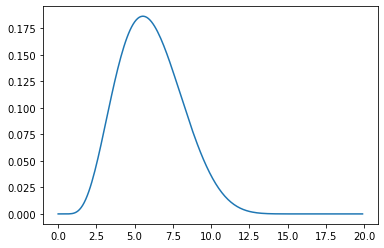

In [2]:
f=compact_support_function(0,20,shape=2.5,skew=0.54,scale=1/5.369727)
xr=np.arange(0,20,0.1)
fig,ax=plt.subplots()
ax.plot(xr,[f(x) for x in xr])
m0=quad(f,0,20)[0]
mean=quad(lambda x: x*f(x),0,20)[0]/m0
variance=quad(lambda x: (x-mean)**2*f(x),0,20)[0]/m0
print(m0,mean,variance)

0.9999999810221457 8.144503130878947 6.495777705687553


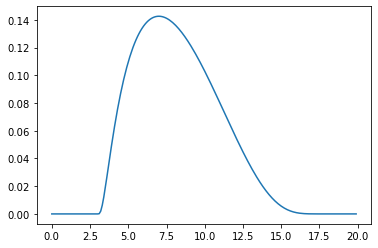

In [3]:
g=compact_support_function(3,19,shape=0.7, skew=0.5,scale=1/7.010836)
xr=np.arange(0,20,0.1)
fig,ax=plt.subplots()
ax.plot(xr,[g(x) for x in xr])
m0=quad(g,0,20)[0]
mean=quad(lambda x: x*g(x),0,20)[0]/m0
variance=quad(lambda x: (x-mean)**2*g(x),0,20)[0]/m0
print(m0,mean,variance)

## Disease profile
The shape of the distribution above is what we use for "symptom onset". We shift infectivity forward by 1 day.
What is called "symptom onset" in the model is really "go in self-isolation", so if people go into self-isolation 5 days after symptom onset, we need to shift it back by 5 days. We also set a symptom onset proportion of $\alpha=0.7$, so about 30% is asymptomatic.

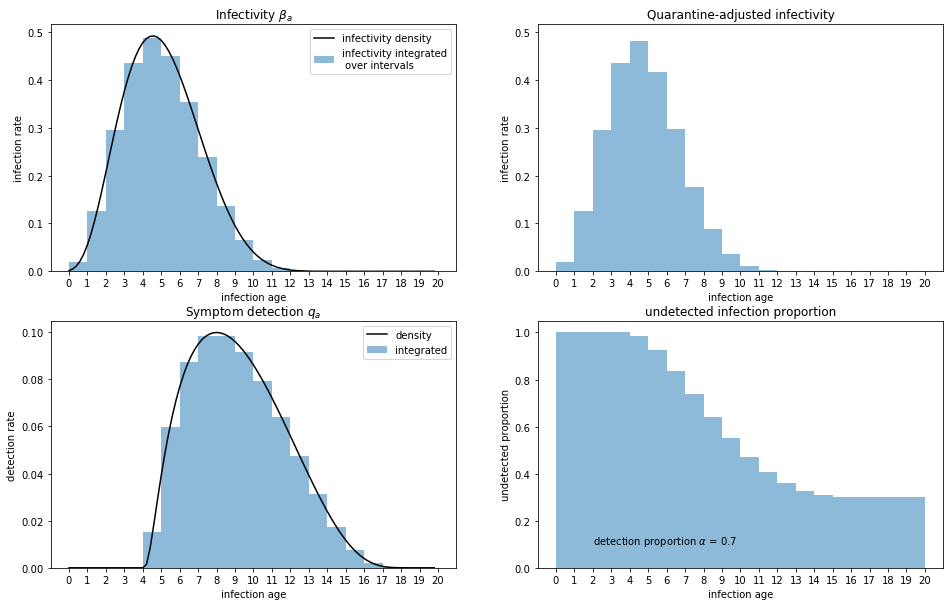

In [4]:
N=20
time_scale=20
POP=5.1e6
I0=2000/POP
def normalized_distributions(alpha,delay,target_R0=2.5):
    orig_scaling=2.5
    beta_dist_orig=lambda a: orig_scaling*f(a+1)
    q_dist=lambda a: alpha*g(a-delay)
    S=simulation(N,beta_dist_orig,q_dist,I0,policy=lambda S,t:(1,1,0,0),time_scale=time_scale)
    measured_R0=S.estimate_R0(n=17)
    scaling=orig_scaling*target_R0/measured_R0
    beta_dist=lambda a: scaling*f(a+1)
    return beta_dist,q_dist
beta_dist,q_dist=normalized_distributions(0.7,1.0)
POP=5.1e6
I0=2000/POP
S=simulation(N,beta_dist,q_dist,I0,policy=lambda S,t:(1,1,0,0),time_scale=time_scale)
fig=S.disease_plots()
fig.savefig("disease_profile.pdf",transparent=True)

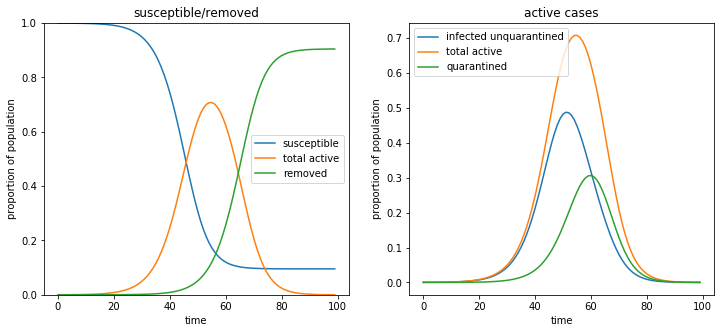

In [5]:
fig=S.time_plots(100)
fig.savefig("reference_timeplot.pdf")

In [6]:
alpha_range=[0.4,0.6,0.8]
delay_range=[0]
tau_range=np.arange(0,1.1,0.02)
R0_estimate_data={}

for alpha in alpha_range:
    for delay in delay_range:
        beta_dist,q_dist=normalized_distributions(alpha,delay)
        tau_range=np.arange(0,1,0.1)
        R0_range1=[]
        R0_range2=[]
        R0_range0=[]
        for tau in tau_range:
            S=simulation(N,beta_dist,q_dist,0.001,policy=lambda S,t:(1,1,0,tau),time_scale=time_scale,tracing_level=1)
            R0_range1.append(S.estimate_R0())
            S=simulation(N,beta_dist,q_dist,0.001,policy=lambda S,t:(1,1,0,tau),time_scale=time_scale,tracing_level=2)
            R0_range2.append(S.estimate_R0())
            S=simulation(N,beta_dist,q_dist,0.001,policy=lambda S,t:(1,1,0,tau),time_scale=time_scale,tracing_level=None)
            R0_range0.append(S.estimate_R0())
        R0_estimate_data[(alpha,delay)]=[tau_range,R0_range0,R0_range1,R0_range2]

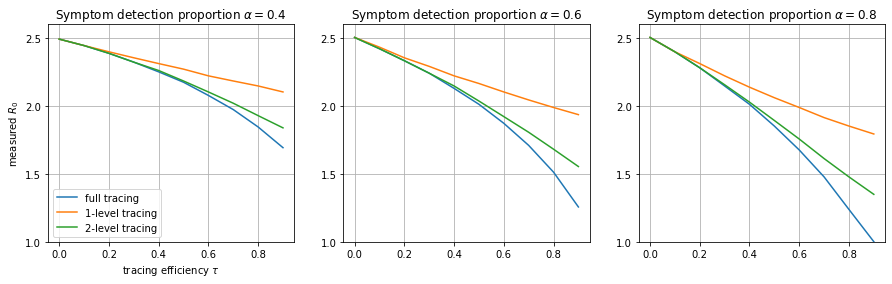

In [7]:
fig,ax=plt.subplots(1,3)
fig.set_size_inches(15,4)
for i in range(3):
    for j in range(1):
        alpha=alpha_range[i]
        delay=delay_range[j]
        tr,r00,r01,r02=R0_estimate_data[(alpha,delay)]
        a=ax[i]
        a.plot(tr,r00,label="full tracing")
        a.plot(tr,r01,label="1-level tracing")
        a.plot(tr,r02,label="2-level tracing")
        if i==0:
            a.legend()
            a.set_xlabel(r"tracing efficiency $\tau$")
            a.set_ylabel(r"measured $R_0$")
        a.grid(True)
        a.set_ylim([1,2.6])
        a.set_yticks([1,1.5,2,2.5])
        a.set_title(r"Symptom detection proportion $\alpha={}$".format(alpha))
fig.savefig("measuredR0.pdf")

In [8]:
N=20
alpha_range=[0.7]
delay_range=[-2,0,2]
tau_range=np.arange(0,1,0.01)
taucrit_data={}

for alpha in alpha_range:
    for delay in delay_range:
        beta_dist,q_dist=normalized_distributions(alpha,delay)
        dist_range=np.arange(0,0.65,0.01)
        tau_vals0=[]
        tau_vals1=[]
        tau_vals2=[]
        traced0=[]
        traced1=[]
        traced2=[]
        active0=[]
        active1=[]
        active2=[]
        quartested0=[]
        quartested1=[]
        quartested2=[]
        
        print(alpha,delay)
        for rr in dist_range:
            S=simulation(N,beta_dist,q_dist,I0=I0,policy=lambda S,t:(1,1-rr,0,0),time_scale=time_scale,tracing_level=0)
            tau0,Scrit=S.bisect_for_tau()
            tau_vals0.append(tau0)
            active0.append(sum(Scrit._Q[-1]+sum(Scrit._I[-1])))
            quartested0.append(Scrit._quartested[-1])
            traced0.append(Scrit._traced[-1])
            S=simulation(N,beta_dist,q_dist,I0=I0,policy=lambda S,t:(1,1-rr,0,0),time_scale=time_scale,tracing_level=1)
            tau1,Scrit=S.bisect_for_tau()
            tau_vals1.append(tau1)
            active1.append(sum(Scrit._Q[-1]+sum(Scrit._I[-1])))
            quartested1.append(Scrit._quartested[-1])
            traced1.append(Scrit._traced[-1])
            S=simulation(N,beta_dist,q_dist,I0=I0,policy=lambda S,t:(1,1-rr,0,0),time_scale=time_scale,tracing_level=2)
            tau2,Scrit=S.bisect_for_tau()
            tau_vals2.append(tau2)
            active2.append(sum(Scrit._Q[-1]+sum(Scrit._I[-1])))
            quartested2.append(Scrit._quartested[-1])
            traced2.append(Scrit._traced[-1])
            taucrit_data[alpha,delay]=[tau_vals0,tau_vals1,tau_vals2,traced0,traced1,traced2,active0,active1,active2,quartested0,quartested1,quartested2]


0.7 -2
0.7 0
0.7 2


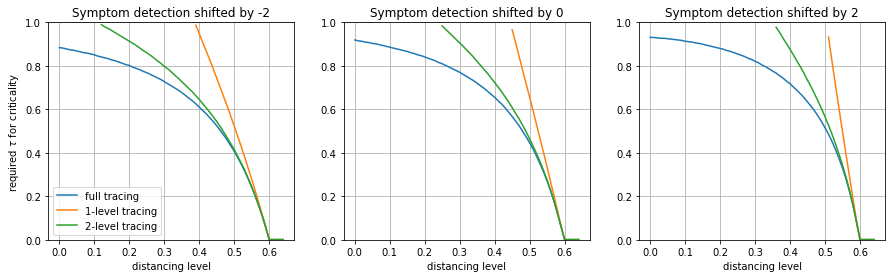

In [11]:
fig,ax=plt.subplots(1,3)
fig.set_size_inches(15,4)
for i in range(1):
    for j in range(3):
        alpha=alpha_range[i]
        delay=delay_range[j]
        xr=np.arange(0,0.65,0.01)
        tau0,tau1,tau2,traced0,traced1,traced2,active0,active1,active2,qt0,qt1,qt2=taucrit_data[(alpha,delay)]
        a=ax[j]
        start0=next(i for i,t in enumerate(tau0) if 0.1<t<0.99)
        start1=next(i for i,t in enumerate(tau1) if 0.1<t<0.99)
        start2=next(i for i,t in enumerate(tau2) if 0.1<t<0.99)
        a.plot(xr[start0:],tau0[start0:],label="full tracing")
        a.plot(xr[start1:],tau1[start1:],label="1-level tracing")
        a.plot(xr[start2:],tau2[start2:],label="2-level tracing")
        a.set_ylim([0,1])
        a.set_title(u"Symptom detection shifted by {}".format(delay))
        a.set_xlabel(u"distancing level")
        a.grid(True)
        if j==0:
            a.legend()
            a.set_ylabel(r"required $\tau$ for criticality")

fig.savefig("multi_taucrit.pdf")

For these critical values, we plot how many quarantines happened due to quarantining, per index case (i.e., someone who was detected)

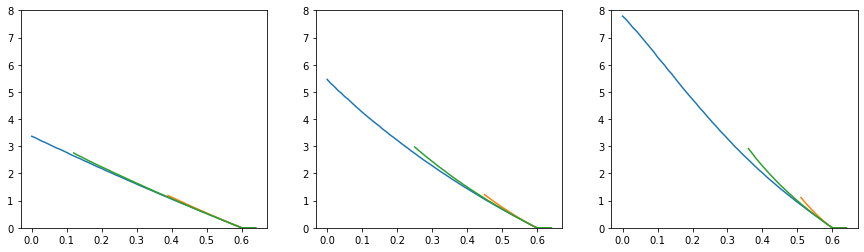

In [12]:
fig,ax=plt.subplots(1,3)
fig.set_size_inches(15,4)
for i in range(1):
    for j in range(3):
        alpha=alpha_range[i]
        delay=delay_range[j]
        xr=np.arange(0,0.65,0.01)
        tau0,tau1,tau2,traced0,traced1,traced2,active0,active1,active2,qt0,qt1,qt2=taucrit_data[(alpha,delay)]
        a=ax[j]
        start0=next(i for i,t in enumerate(tau0) if 0.1<t<0.99)
        start1=next(i for i,t in enumerate(tau1) if 0.1<t<0.99)
        start2=next(i for i,t in enumerate(tau2) if 0.1<t<0.99)
        L0=[a/b for a,b in zip(traced0[start0:],qt0[start0:])]
        L1=[a/b for a,b in zip(traced1[start1:],qt1[start1:])]
        L2=[a/b for a,b in zip(traced2[start2:],qt2[start2:])]
        a.plot(xr[start0:],L0,label="full tracing")
        a.plot(xr[start1:],L1,label="1-level tracing")
        a.plot(xr[start2:],L2,label="2-level tracing")
        a.set_ylim([0,8])
fig.savefig("multi_traceprop.pdf")

and the number of quarantines due to tracing as a proportion of the number of active cases (just to have a scaling factor in mind)

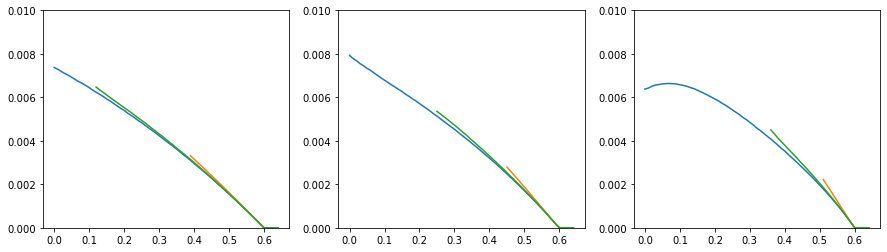

In [13]:
fig,ax=plt.subplots(1,3)
fig.set_size_inches(15,4)
for i in range(1):
    for j in range(3):
        alpha=alpha_range[i]
        delay=delay_range[j]
        xr=np.arange(0,0.65,0.01)
        tau0,tau1,tau2,traced0,traced1,traced2,active0,active1,active2,qt0,qt1,qt2=taucrit_data[(alpha,delay)]
        a=ax[j]
        start0=next(i for i,t in enumerate(tau0) if 0.1<t<0.99)
        start1=next(i for i,t in enumerate(tau1) if 0.1<t<0.99)
        start2=next(i for i,t in enumerate(tau2) if 0.1<t<0.99)
        L0=[a/b for a,b in zip(traced0[start0:],active0[start0:])]
        L1=[a/b for a,b in zip(traced1[start1:],active1[start1:])]
        L2=[a/b for a,b in zip(traced2[start2:],active2[start2:])]
        a.plot(xr[start0:],L0,label="full tracing")
        a.plot(xr[start1:],L1,label="1-level tracing")
        a.plot(xr[start2:],L2,label="2-level tracing")
        a.set_ylim([0,0.01])
fig.savefig("multi_traceprop.pdf")

To put the results in perspective, let's compare with random surveillance testing as a tool to increase quarantined cases. This is quite unrealistic, because we'll see one needs incredible testing numbers. Plus, these numbers assume the test we administer is perfectly sensitive, from day 1. The results below express what proportion of the total population one would have to test per day to suppress the epidemic.

In [15]:
N=20
alpha_range=[0.7]
delay_range=[-2,0,2]
tau_range=np.arange(0,1,0.01)
testcrit_data={}

for alpha in alpha_range:
    for delay in delay_range:
        beta_dist,q_dist=normalized_distributions(alpha,delay)
        dist_range=np.arange(0,0.65,0.01)
        test_vals=[]
        print(alpha,delay)
        for rr in dist_range:
            S=simulation(N,beta_dist,q_dist,I0=I0*0.01,policy=lambda S,t:(1,1-rr,0,0),time_scale=time_scale,tracing_level=0)
            test0,Scrit=S.bisect_for_testing(mx=0.3)
            test_vals.append(test0)
        testcrit_data[alpha,delay]=[dist_range,test_vals]

0.7 -2
0.7 0
0.7 2


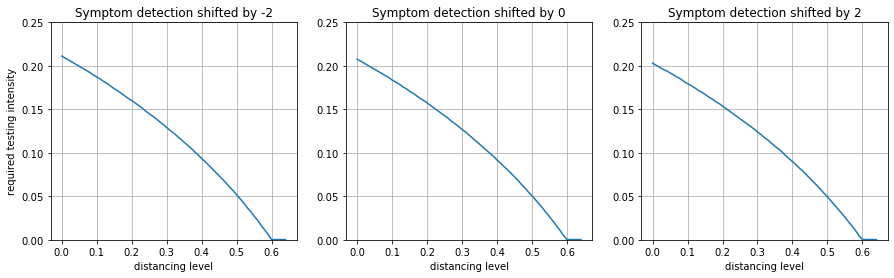

In [16]:
fig,ax=plt.subplots(1,3)
fig.set_size_inches(15,4)
for i in range(1):
    for j in range(3):
        alpha=alpha_range[i]
        delay=delay_range[j]
        xr,testing=testcrit_data[(alpha,delay)]
        a=ax[j]
        a.plot(xr,testing)
        a.set_ylim([0,0.25])
        a.set_title(u"Symptom detection shifted by {}".format(delay))
        a.set_xlabel(u"distancing level")
        a.grid(True)
        if j==0:
            a.set_ylabel(r"required testing intensity")
fig.savefig("required_testing.pdf")